# Multivariate Analysis

In [2]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [44]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [45]:
%store -r df_nadal
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r X_final
%store -r y_final

In [7]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [46]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [47]:
X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL',
       'AT_Y', 'AT_Z','AU_428_FR','AU_428_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_BR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), ElasticNet(alpha=0.001, l1_ratio=0.2)]

Obtaining R2 score for all 6 models


 17%|█▋        | 1/6 [00:00<00:00,  7.32it/s]c:\Users\DELL\Desktop\PG\Sparse_Sensing\utils\feature_importance.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [00:21<00:49, 12.43s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 50%|█████     | 3/6 [00:30<00:33, 11.13s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [00:56<00:33, 16.76s/it]c:\Users\DELL\Desktop\PG\Sparse_Sensing\utils\feature_importance.py:150: DataConversionWarning:

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 100%
CPU times: total: 2min 9s
Wall time: 1min 5s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

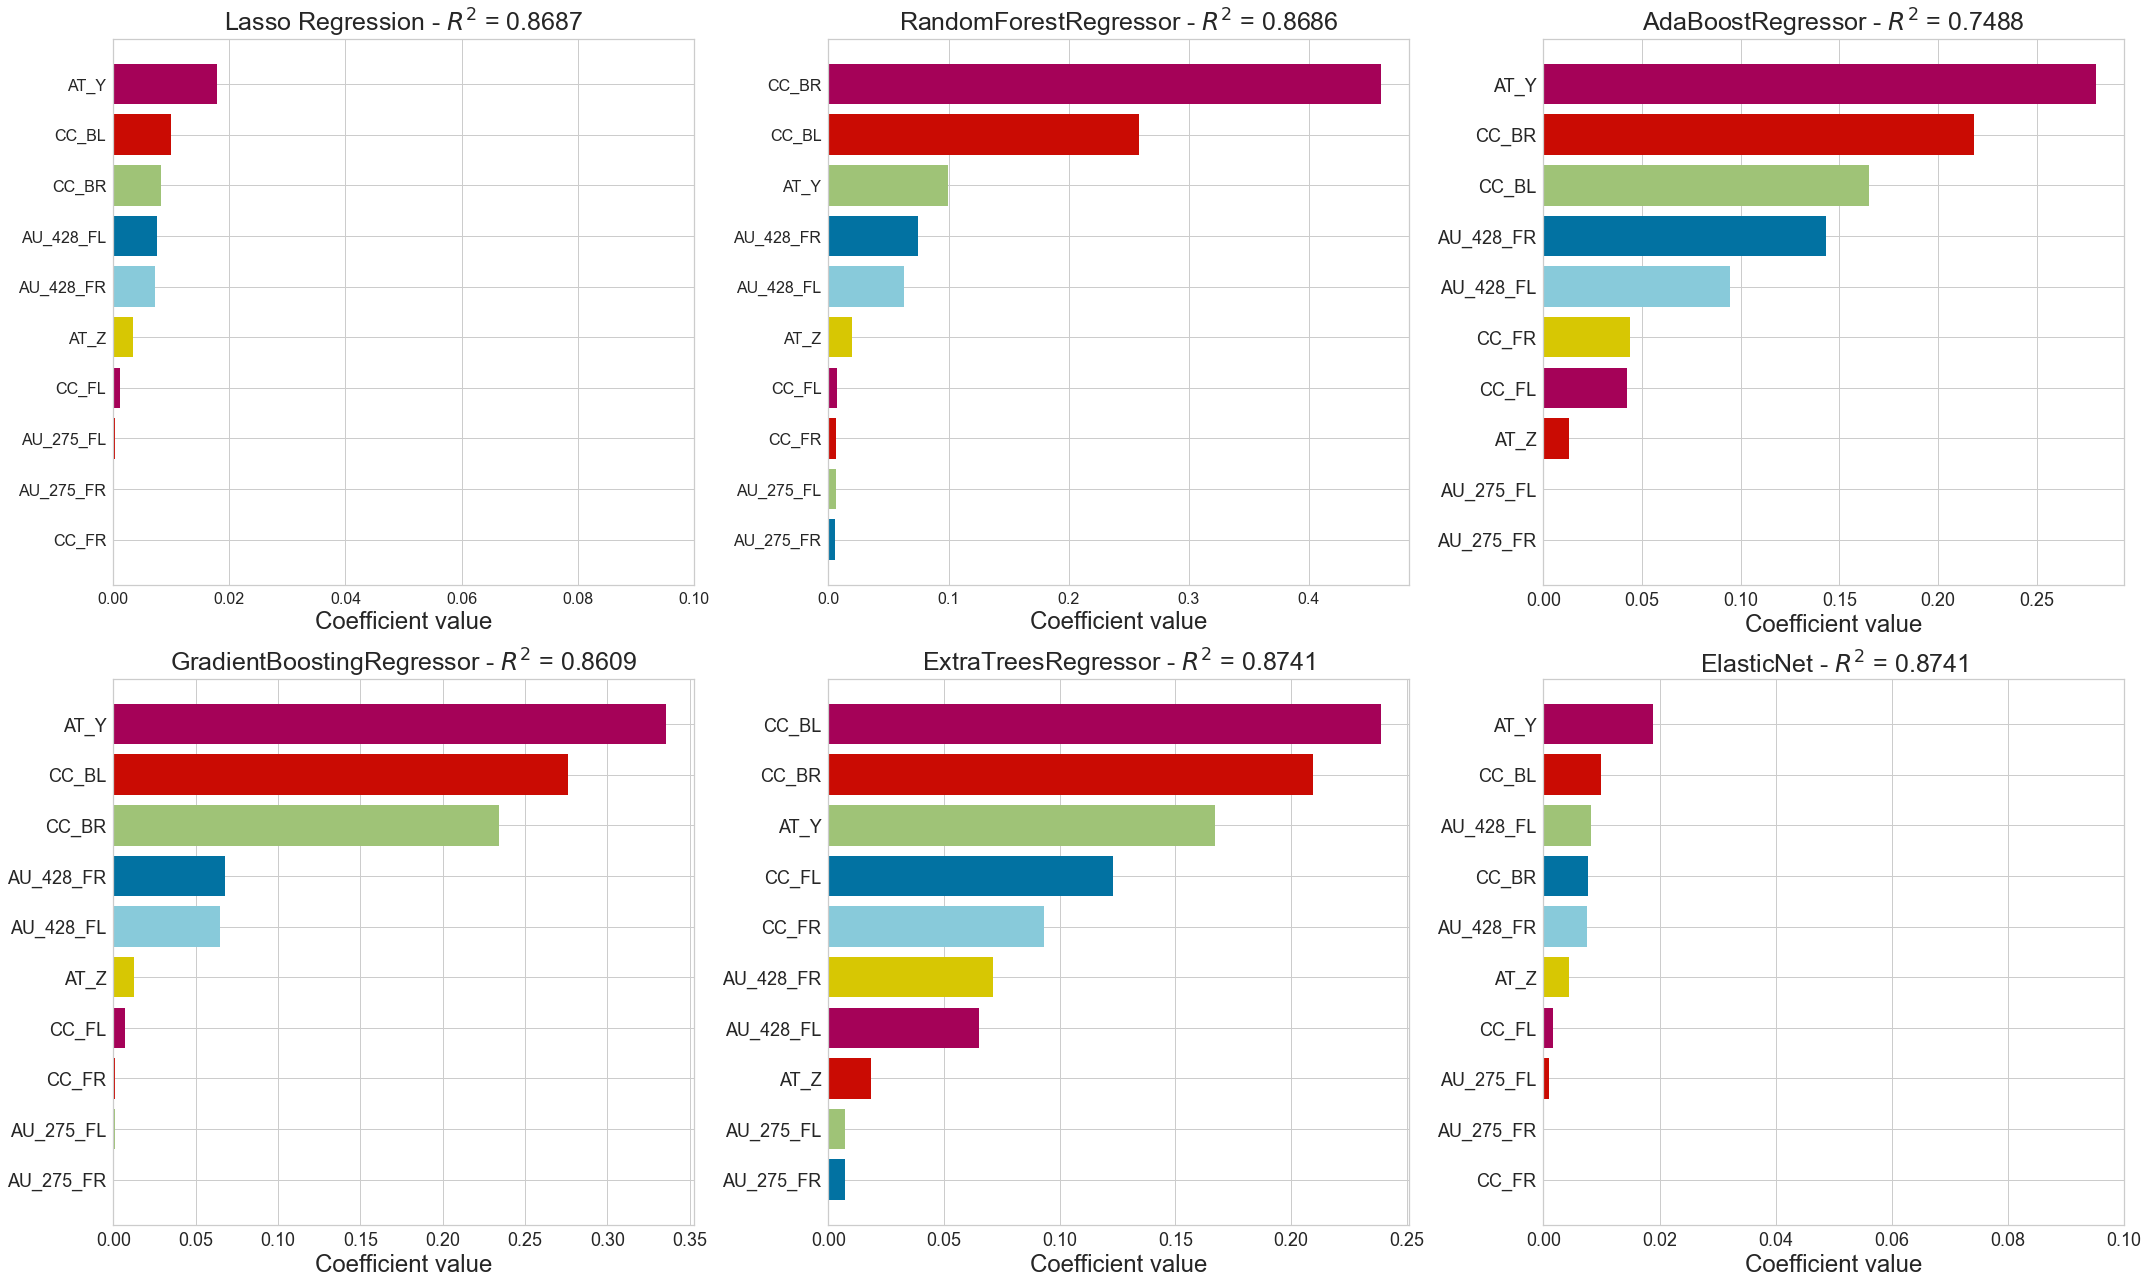

In [48]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [58]:
X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL',
       'AT_Y','AT_Z','AU_428_FR','AU_428_FL']], df_nadal[['L/V_BR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

In [50]:
#data into numpy
X_train_final= X_train_scaled.to_numpy()
X_test_final= X_test_scaled.to_numpy()
y_train_final= y_train.to_numpy()
y_train_final = y_train_final.reshape(-1, 1)
y_test_final= y_test.to_numpy()
y_test_final = y_test_final.reshape(-1, 1)

### Random Forest - FR

In [59]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=20,high=200,step=10)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=8, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=8, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-23 18:08:44,714] A new study created in memory with name: no-name-eae76207-fc73-451d-b722-15c51d0ddbee
C:\Users\DELL\AppData\Local\Temp\ipykernel_2208\533185038.py:24: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2022-11-23 18:08:52,752] Trial 0 finished with value: 0.8704970528414216 and parameters: {'n_estimators': 90, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4, 'max_features': 4}. Best is trial 0 with value: 0.8704970528414216.
C:\Users\DELL\AppData\Local\Temp\ipykernel_2208\533185038.py:24: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2022-11-23 18:09:00,502] Trial 1 finished with value: 0.8708859522406424 and parameters: {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 7, 'min_samples_split': 3, 'max_features': 4}.

Accuracy: 0.871975969045627
Best hyperparameters: {'n_estimators': 160, 'max_depth': 38, 'min_samples_leaf': 4, 'min_samples_split': 4, 'max_features': 4}


melhor score r2 0.7291 <br>
Best hyperparameters: {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 5, Best hyperparameters: {'n_estimators': 160, 'max_depth': 14, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 5}

In [54]:
study.best_trial

FrozenTrial(number=13, values=[0.7291587014172538], datetime_start=datetime.datetime(2022, 11, 23, 17, 34, 34, 444004), datetime_complete=datetime.datetime(2022, 11, 23, 17, 34, 46, 836876), params={'n_estimators': 160, 'max_depth': 14, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 5}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=20, step=10), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=8, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=8, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE, value=None)

In [55]:
optuna.visualization.plot_optimization_history(study)

In [56]:
optuna.visualization.plot_slice(study)

### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=20, high=500, step=1)
    h_learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_final,y_train_final)
    p=model.predict(X_test_final)
    score= r2_score(y_test_final,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')
study_ab.optimize(objective, n_trials=100)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

[I 2022-11-22 16:39:49,803] A new study created in memory with name: no-name-e0fc4147-2a72-4fe0-98a5-c93f9492089f
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-11-22 16:40:06,303] Trial 0 finished with value: 0.8889603558038552 and parameters: {'n_estimators': 156, 'learning_rate': 0.6099900386234557, 'loss': 'exponential'}. Best is trial 0 with value: 0.8889603558038552.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-11-22 16:40:46,626] Trial 1 finished with value: 0.8896065503148924 and parameters: {'n_estimators': 446, 'learning_rate': 0.7149121813241174, 'loss': 'exp

Accuracy: 0.9013347174113231
Best hyperparameters: {'n_estimators': 212, 'learning_rate': 0.9311107326380043, 'loss': 'square'}


Melhor score r2: Accuracy: 0.9013347174113231 <br>
Best hyperparameters: {'n_estimators': 212, 'learning_rate': 0.9311107326380043, 'loss': 'square'}

In [35]:
optuna.visualization.plot_optimization_history(study_ab)

In [36]:
optuna.visualization.plot_slice(study_ab)

In [42]:
import xgboost as XGBRegressor

def objective(trial):
    
        
    x_max_depth = trial.suggest_int("max_depth",2,20)
    x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    
    model = XGBRegressor(max_depth = x_max_depth,
                                 learning_rate = x_learning_rate,
                                 n_estimators = x_n_estimators,
                                 colsample_bytree = x_colsample_bytree,
                                 min_child_weight  =x_min_child_weight,
                                                                 
                                 random_state=0,
                                 n_jobs=-1)
    
    

    return score_method(model, trial)
    model.fit(X_train_final,y_train_final)
    p=model.predict(X_test_final)
    score= r2_score(y_test_final,p)
    return score

    
study_xgbr= optuna.create_study(direction='maximize')
study_xgbr.optimize(objective, n_trials=100)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

[I 2022-11-23 15:02:37,736] A new study created in memory with name: no-name-122f0fd3-d9f4-4671-8458-1cba634eea52
[W 2022-11-23 15:02:37,741] Trial 0 failed because of the following error: TypeError("'module' object is not callable")
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_2208\3922586605.py", line 12, in objective
    model = XGBRegressor(max_depth = x_max_depth,
TypeError: 'module' object is not callable


TypeError: 'module' object is not callable